## Demand Forecasting Using Prophet on Quik Data

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import pickle


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

### Reading in Data


In [3]:
df = pd.read_csv('quik_data_all_cleaned.csv')
df.columns = df.columns.str.lower()
df['order_received_timestamp'] = pd.to_datetime(df['order_received_timestamp'], errors='coerce')


In [4]:
min(df['order_received_timestamp']), max(df['order_received_timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2024-02-29 23:40:00'))

In [5]:
df.head()

merchant_id order_received_timestamp  order_count
0  merchant_1      2023-12-01 00:00:00            1
1  merchant_1      2023-12-01 00:20:00            2
2  merchant_1      2023-12-01 00:40:00            3
3  merchant_1      2023-12-01 01:00:00            2
4  merchant_1      2023-12-01 01:20:00            3

In [6]:
agg_df = df.groupby(['order_received_timestamp', 'merchant_id']).agg({'order_count': 'sum'}).reset_index().sort_values(['merchant_id', 'order_received_timestamp']) #groups the dataframe


In [7]:
agg_df.head()

order_received_timestamp merchant_id  order_count
0       2023-12-01 00:00:00  merchant_1            1
7       2023-12-01 00:20:00  merchant_1            2
15      2023-12-01 00:40:00  merchant_1            3
24      2023-12-01 01:00:00  merchant_1            2
33      2023-12-01 01:20:00  merchant_1            3

In [8]:
agg_df.tail()

order_received_timestamp merchant_id  order_count
70659      2024-02-29 22:20:00  merchant_9            1
70671      2024-02-29 22:40:00  merchant_9            1
70682      2024-02-29 23:00:00  merchant_9            2
70691      2024-02-29 23:20:00  merchant_9            0
70699      2024-02-29 23:40:00  merchant_9            2

In [9]:
total_orders_df = agg_df.pivot(index='order_received_timestamp', columns='merchant_id', values='order_count')
total_orders_df.tail()

merchant_id               merchant_1  merchant_10  merchant_11  merchant_12  \
order_received_timestamp                                                      
2024-02-29 22:20:00             3.00         4.00         0.00         1.00   
2024-02-29 22:40:00             1.00         5.00         2.00         0.00   
2024-02-29 23:00:00             1.00         3.00         1.00         1.00   
2024-02-29 23:20:00             1.00         2.00         0.00          NaN   
2024-02-29 23:40:00             2.00         3.00         1.00          NaN   

merchant_id               merchant_2  merchant_3  merchant_4  merchant_5  \
order_received_timestamp                                                   
2024-02-29 22:20:00             0.00        1.00        1.00        2.00   
2024-02-29 22:40:00             2.00        1.00        4.00        1.00   
2024-02-29 23:00:00             2.00        3.00        3.00        2.00   
2024-02-29 23:20:00             4.00        1.00        2.00        0.00   
2024-02-29 23:40:00             1.00        1.00         NaN        1.00   

merchant_id               merchant_6  merchant_7  merchant_8  merchant_9  
order_received_timestamp                                                  
2024-02-29 22:20:00             1.00        4.00        5.00        1.00  
2024-02-29 22:40:00             2.00        3.00        1.00        1.00  
2024-02-29 23:00:00             1.00         NaN        1.00        2.00  
2024-02-29 23:20:00              NaN         NaN        3.00        0.00  
2024-02-29 23:40:00              NaN         NaN        1.00        2.00

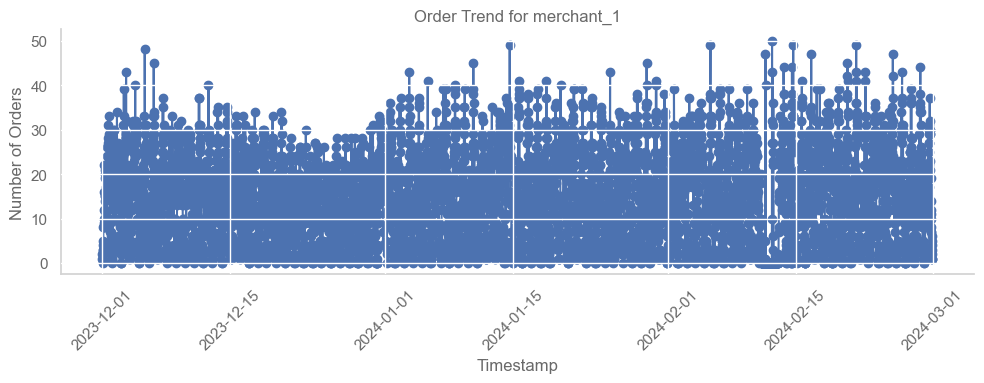

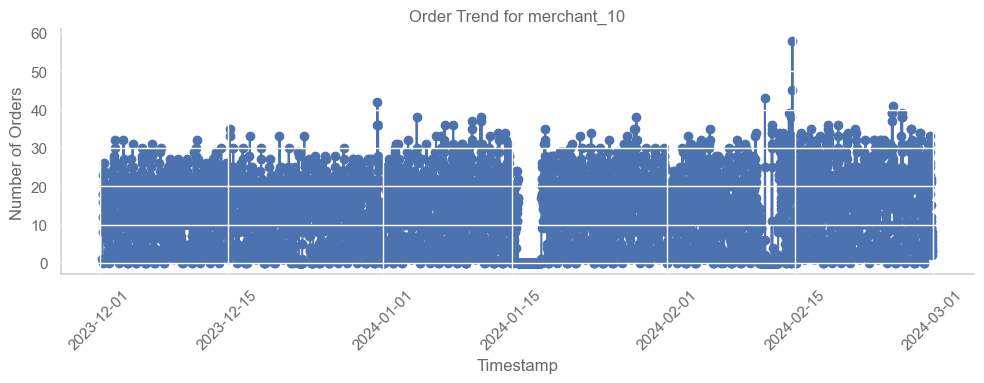

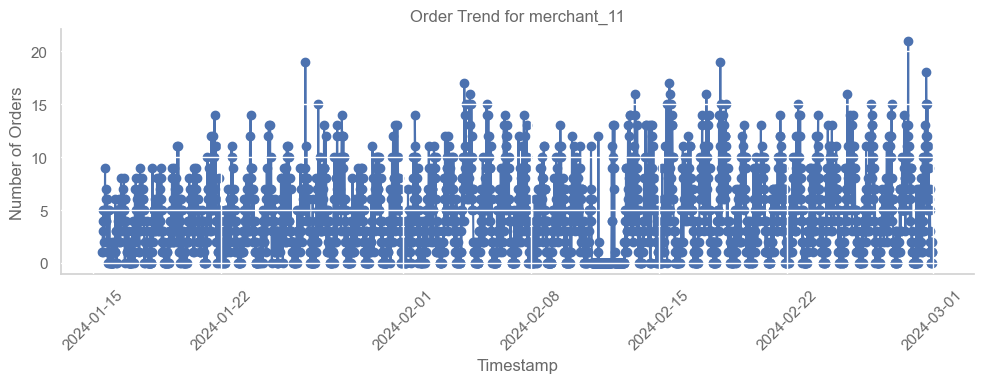

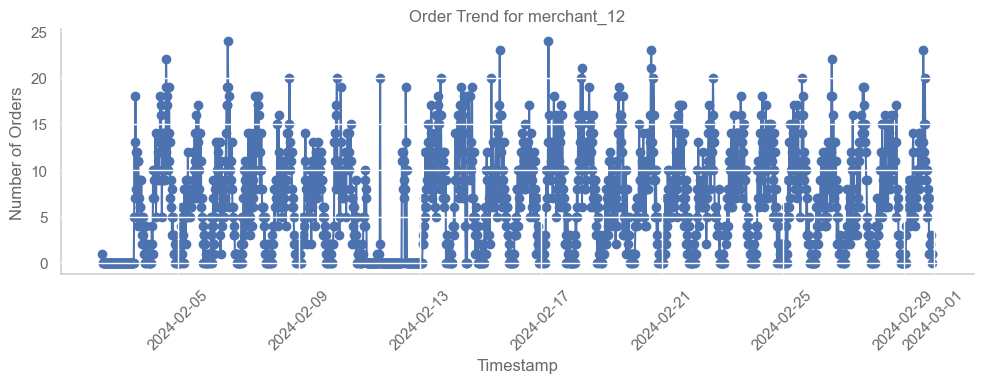

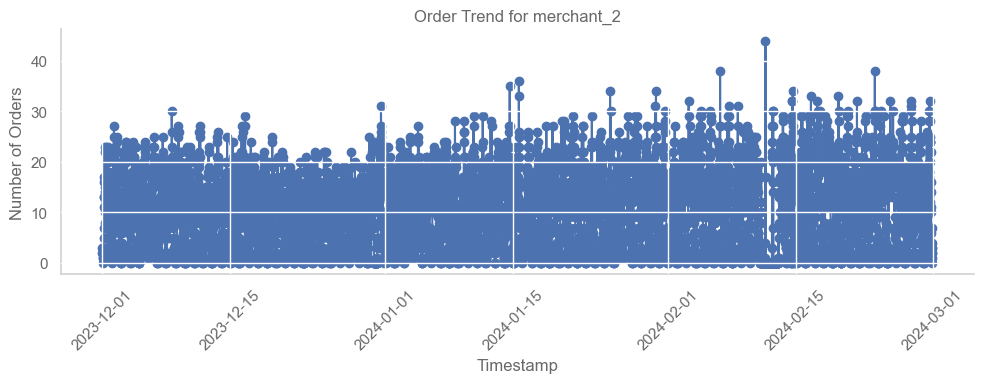

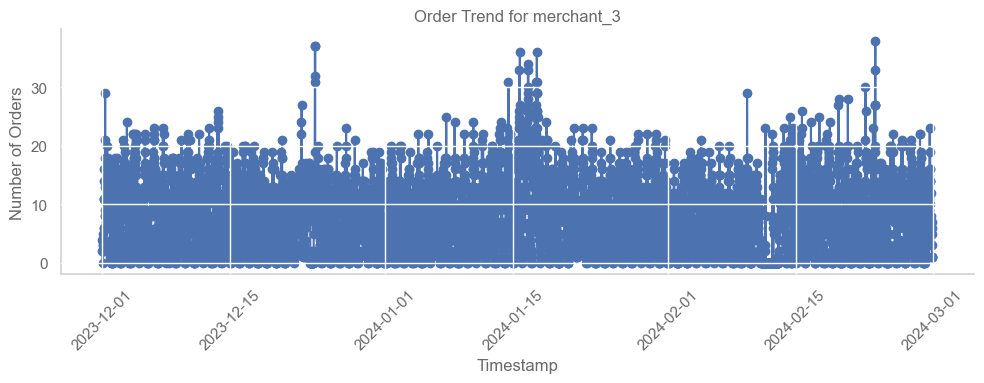

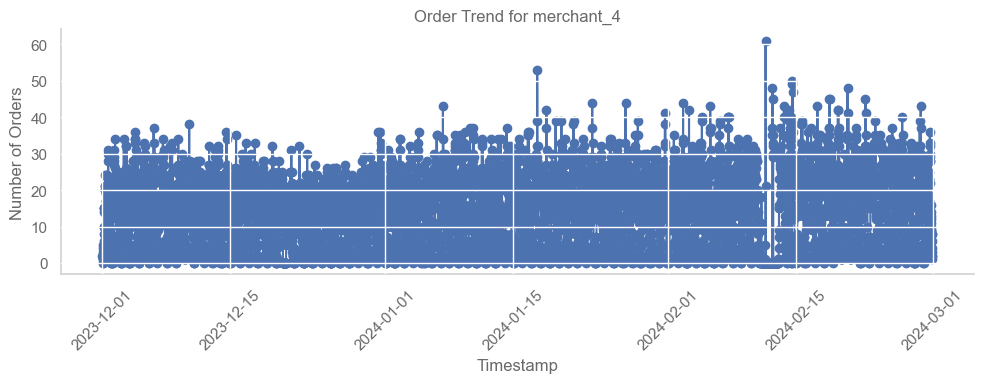

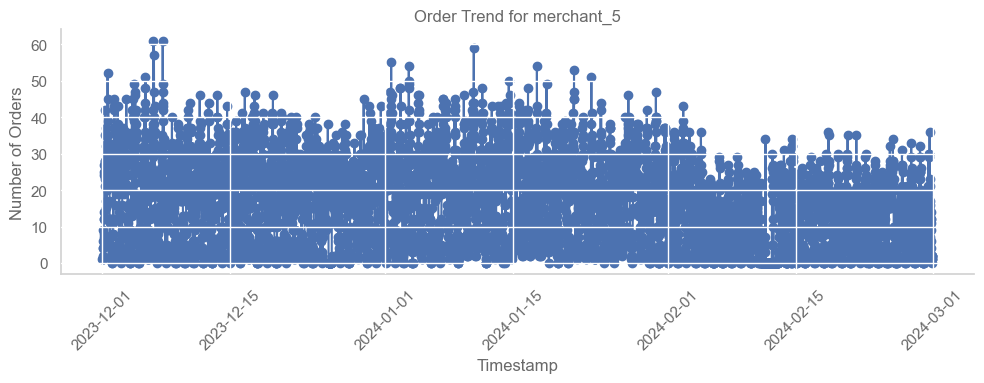

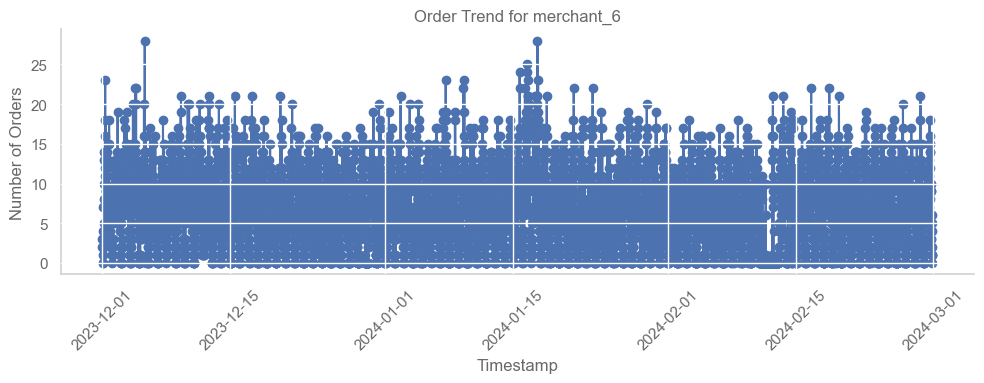

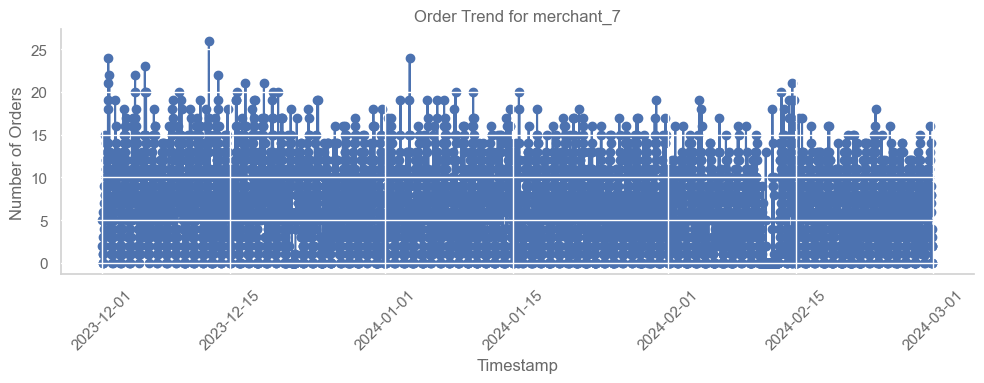

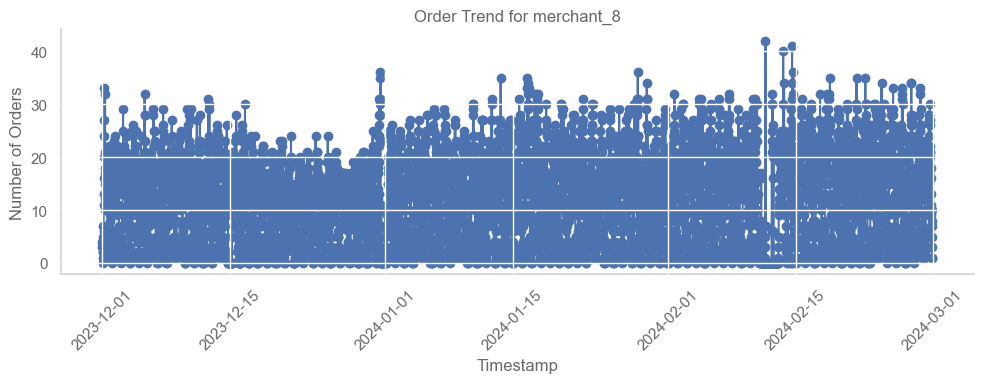

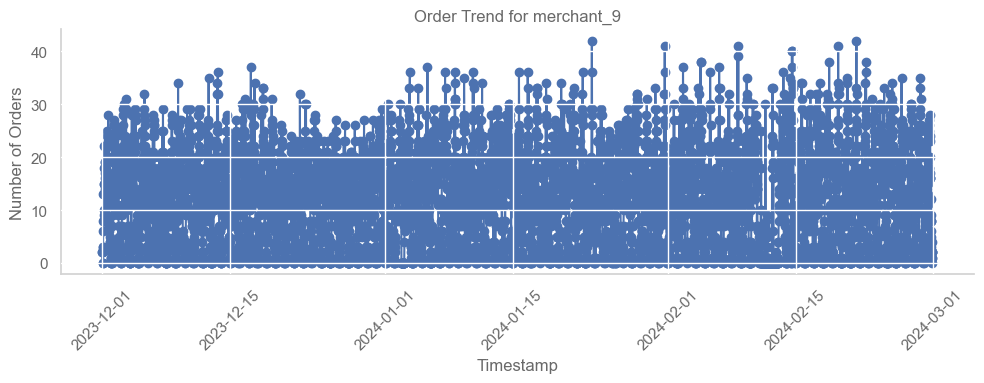

In [10]:
for column in total_orders_df.columns:
    plt.figure(figsize=(10, 4))  
    plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
    plt.title(f"Order Trend for {column}")
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Orders')
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

In [11]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01'] #data starts Dec 1st


In [12]:
missing_data(total_orders_df) #checks for null values for each merchant

Total  Percent    Types
merchant_id                         
merchant_1      25     0.38  float64
merchant_10     23     0.35  float64
merchant_11   3285    50.14  float64
merchant_12   4573    69.80  float64
merchant_2       0     0.00  float64
merchant_3       0     0.00  float64
merchant_4       4     0.06  float64
merchant_5       0     0.00  float64
merchant_6       3     0.05  float64
merchant_7       6     0.09  float64
merchant_8       1     0.02  float64
merchant_9       4     0.06  float64

In [13]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros
#assuming there was no orders at that 20 minute period for that merchant

missing_data(total_orders_df) #check missing values again to make sure there's none

Total  Percent    Types
merchant_id                         
merchant_1       0     0.00  float64
merchant_10      0     0.00  float64
merchant_11      0     0.00  float64
merchant_12      0     0.00  float64
merchant_2       0     0.00  float64
merchant_3       0     0.00  float64
merchant_4       0     0.00  float64
merchant_5       0     0.00  float64
merchant_6       0     0.00  float64
merchant_7       0     0.00  float64
merchant_8       0     0.00  float64
merchant_9       0     0.00  float64

#### This section groups merchants by the volume of data. The higher volume data the better for forecasting since we can forecast past the noise and end up with lower error bars. This helped understand why some merchats had higher error bars than other merchants (['merchant_12', 'merchant_11', 'merchant_7', 'merchant_6'])

### Category Grouping

In [14]:
avg_daily_orders = total_orders_df.apply(np.mean, axis=0).sort_values() #typical order volume per merchant across all timestamps.

low, mid = np.percentile(avg_daily_orders, [33, 66]) #thresholds for low, mid, and high order volumes.


In [15]:
# Create lists of merchants based on order volume categories
low_vol_columns = list(avg_daily_orders[avg_daily_orders <= low].index)
mid_vol_columns = list(avg_daily_orders[(avg_daily_orders > low) & (avg_daily_orders < mid)].index)
high_vol_columns = list(avg_daily_orders[avg_daily_orders >= mid].index)



In [16]:
high_vol_columns

['merchant_10', 'merchant_1', 'merchant_4', 'merchant_5']

In [17]:
low_vol_columns

['merchant_12', 'merchant_11', 'merchant_7', 'merchant_6']

In [18]:
# plt.figure(figsize=(12, 6))  
# for merchant in low_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Low Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best')  
# plt.grid(True)  
# plt.xticks(rotation=45)  
# plt.tight_layout() 
# plt.show()

In [19]:
# plt.figure(figsize=(12, 6)) 
# for merchant in mid_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Mid Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Positioning the legend outside the plot area
# plt.grid(True)  # Adding a grid for better readability
# plt.xticks(rotation=30)  
# plt.tight_layout() 
# plt.show()

In [20]:
# plt.figure(figsize=(12, 6))  # Set a suitable figure size
# for merchant in high_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for High Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Properly title the legend and adjust its position
# plt.xticks(rotation=30)
# plt.grid(True)  # Optionally add a grid
# plt.tight_layout()  # Adjust layout
# plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [21]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
seasonality_mode_options = ['additive', 'multiplicative']
changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [22]:
# Tuning for the above five hyperparameters (takes more than 24 hours running)
# start_time = time.time()

# dicts = {}

# for feature in total_orders_df.columns:
  
#     category_df = total_orders_df[feature].copy().reset_index()
#     category_df.columns = ["ds", "y"]

#     category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
#     category_df["ds"] = pd.to_datetime(category_df["ds"])
    
#     param_grid = {  
#         "changepoint_prior_scale": changepoint_prior_scale_range,
#         "seasonality_prior_scale": seasonality_prior_scale_range,
#         'holidays_prior_scale': holidays_prior_scale_range,
#         'seasonality_mode': seasonality_mode_options,
#         'changepoint_range': changepoint_range_range}

#     # Generate all combinations of parameters
#     all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#     rmses = []
#     maes = []

#     # Use cross validation to evaluate all parameters
#     for params in all_params:
#         m = Prophet(**params).fit(category_df)  # Fit model with given params
#         df_cv = cross_validation(m, initial="60 days", period="5 days", horizon = "1 days") 
#         df_p = performance_metrics(df_cv, rolling_window=1)
#         print(df_p)
#         rmses.append(df_p["rmse"].values[0])
#         maes.append(df_p["mae"].values[0])

#     # Find the best parameters
#     tuning_results = pd.DataFrame(all_params)
#     tuning_results["rmse"] = rmses
#     tuning_results["mae"] = maes

#     params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
#     params_dict["column"] = feature 
    
#     dicts[feature] = params_dict

# print("--- %s seconds ---" % (time.time() - start_time)) 

Here is a dictionary of the optimized parameters for each merchant. 

In [23]:
dicts = {'merchant_1': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.95,
  'rmse': 5.346744162497519,
  'mae': 3.852302697069816,
  'column': 'merchant_1'},
 'merchant_10': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 7.5024999999999995,
  'holidays_prior_scale': 2.5075,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.6125,
  'rmse': 5.702391812737375,
  'mae': 3.9351553994779587,
  'column': 'merchant_10'},
 'merchant_11': {'changepoint_prior_scale': 0.37525,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.6125,
  'rmse': 2.667122482438804,
  'mae': 2.0406928669112308,
  'column': 'merchant_11'},
 'merchant_12': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 2.5075,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.95,
  'rmse': 4.746561051167551,
  'mae': 3.6881798834714523,
  'column': 'merchant_12'},
 'merchant_2': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 2.5075,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.6125,
  'rmse': 4.596940096872507,
  'mae': 3.3857124505769667,
  'column': 'merchant_2'},
 'merchant_3': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 5.005,
  'seasonality_mode': 'additive',
  'changepoint_range': 0.725,
  'rmse': 3.6419303350758576,
  'mae': 2.675335282286456,
  'column': 'merchant_3'},
 'merchant_4': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.6125,
  'rmse': 5.997254304956817,
  'mae': 4.205430554043922,
  'column': 'merchant_4'},
 'merchant_5': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 10.0,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.95,
  'rmse': 5.396273930064865,
  'mae': 3.802044109435989,
  'column': 'merchant_5'},
 'merchant_6': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'additive',
  'changepoint_range': 0.5,
  'rmse': 3.0966897508138973,
  'mae': 2.2948892139948858,
  'column': 'merchant_6'},
 'merchant_7': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 5.005,
  'holidays_prior_scale': 10.0,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.5,
  'rmse': 2.9498544579758064,
  'mae': 2.1176242055391263,
  'column': 'merchant_7'},
 'merchant_8': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'holidays_prior_scale': 7.5024999999999995,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.95,
  'rmse': 4.654728962234435,
  'mae': 3.337157483274598,
  'column': 'merchant_8'},
 'merchant_9': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'holidays_prior_scale': 7.5024999999999995,
  'seasonality_mode': 'multiplicative',
  'changepoint_range': 0.5,
  'rmse': 5.368651244851184,
  'mae': 3.81503094675507,
  'column': 'merchant_9'}}


### HOLIDAY DATA

In [24]:
# Initialize the holiday DataFrame
holiday = pd.DataFrame([])

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': [date_], 'holiday': ["UAE-Holidays"], 'lower_window': [-2], 'upper_window': [1]})], ignore_index=True)

# Manually add December 30 and 31 holidays
# We can add other desired hollidays manually if not in the holiday DataFrame
manual_holidays = pd.DataFrame({
    'ds': ['2023-12-30', '2023-12-31'],
    'holiday': ['Manual-Holiday', 'Manual-Holiday'],
    'lower_window': [-2, -2],
    'upper_window': [1, 1]
})

# Convert 'ds' to datetime
manual_holidays['ds'] = pd.to_datetime(manual_holidays['ds'])

# Append manual holidays to the holiday DataFrame
holiday = pd.concat([holiday, manual_holidays], ignore_index=True)

# Convert 'ds' to datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Display the updated holiday DataFrame
print(holiday.head(10))
print(holiday.tail(10))


          ds       holiday  lower_window  upper_window
0 2023-01-01  UAE-Holidays            -2             1
1 2023-04-20  UAE-Holidays            -2             1
2 2023-04-21  UAE-Holidays            -2             1
3 2023-04-22  UAE-Holidays            -2             1
4 2023-04-23  UAE-Holidays            -2             1
5 2023-06-27  UAE-Holidays            -2             1
6 2023-06-28  UAE-Holidays            -2             1
7 2023-06-29  UAE-Holidays            -2             1
8 2023-06-30  UAE-Holidays            -2             1
9 2023-07-21  UAE-Holidays            -2             1
           ds         holiday  lower_window  upper_window
18 2024-06-15    UAE-Holidays            -2             1
19 2024-06-16    UAE-Holidays            -2             1
20 2024-06-17    UAE-Holidays            -2             1
21 2024-06-18    UAE-Holidays            -2             1
22 2024-07-07    UAE-Holidays            -2             1
23 2024-09-15    UAE-Holidays            -2    

C:\Users\Nourhan\AppData\Local\Temp\ipykernel_21780\3431846932.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


### BACKTESTING WITH TUNED METRICS

In [25]:
prediction_days = 1 # Forecast for the next day only
forecast_start_date = max(total_orders_df.index) - timedelta(prediction_days) 

In [26]:
forecast_start_date

Timestamp('2024-02-28 23:40:00')

16:06:07 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing


merchant_1 - RMSE: 3.67, MAE: 2.88


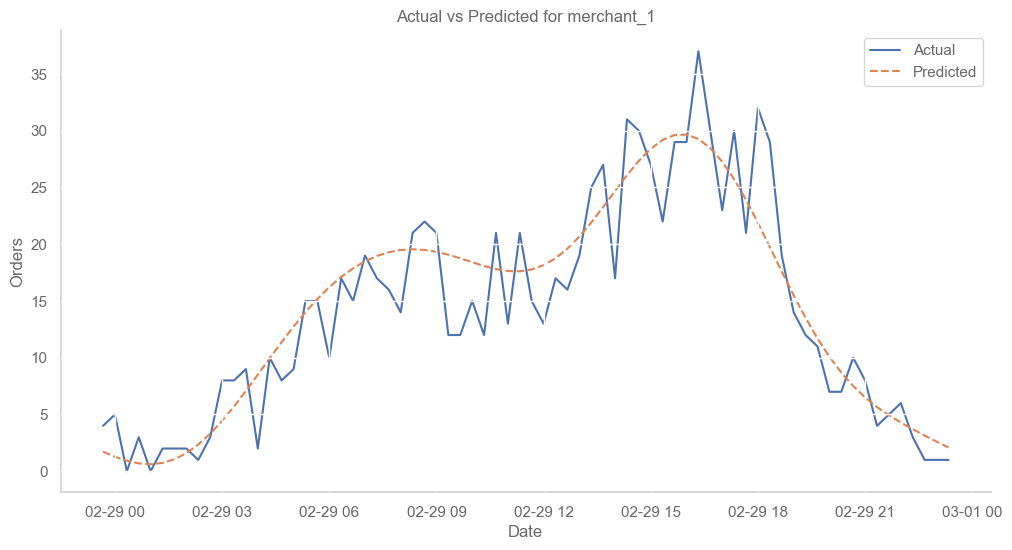

16:06:12 - cmdstanpy - INFO - Chain [1] start processing
16:06:18 - cmdstanpy - INFO - Chain [1] done processing


merchant_10 - RMSE: 3.86, MAE: 2.93


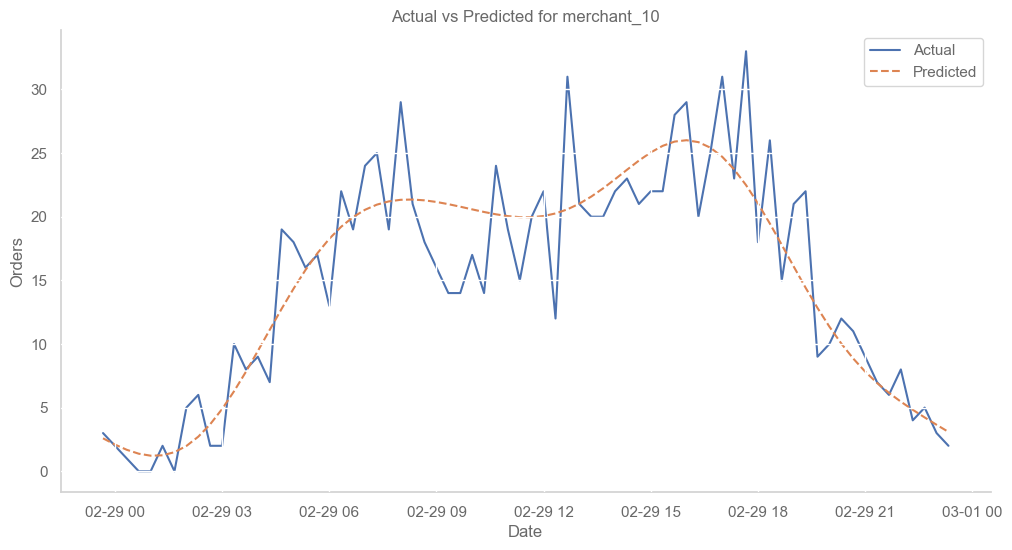

16:06:22 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing


merchant_11 - RMSE: 2.72, MAE: 2.05


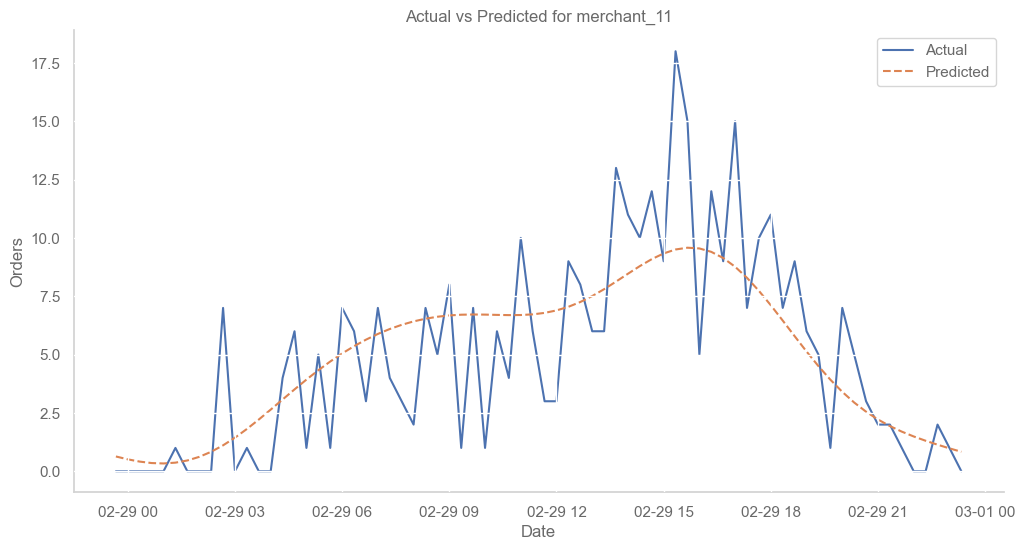

16:06:36 - cmdstanpy - INFO - Chain [1] start processing
16:06:46 - cmdstanpy - INFO - Chain [1] done processing


merchant_12 - RMSE: 3.32, MAE: 2.57


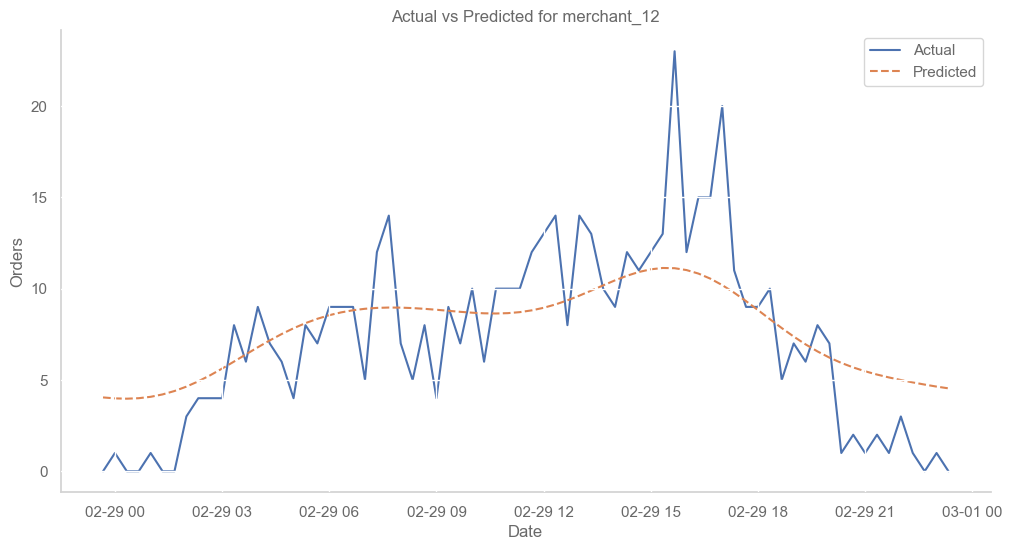

16:06:52 - cmdstanpy - INFO - Chain [1] start processing
16:06:53 - cmdstanpy - INFO - Chain [1] done processing


merchant_2 - RMSE: 4.23, MAE: 3.19


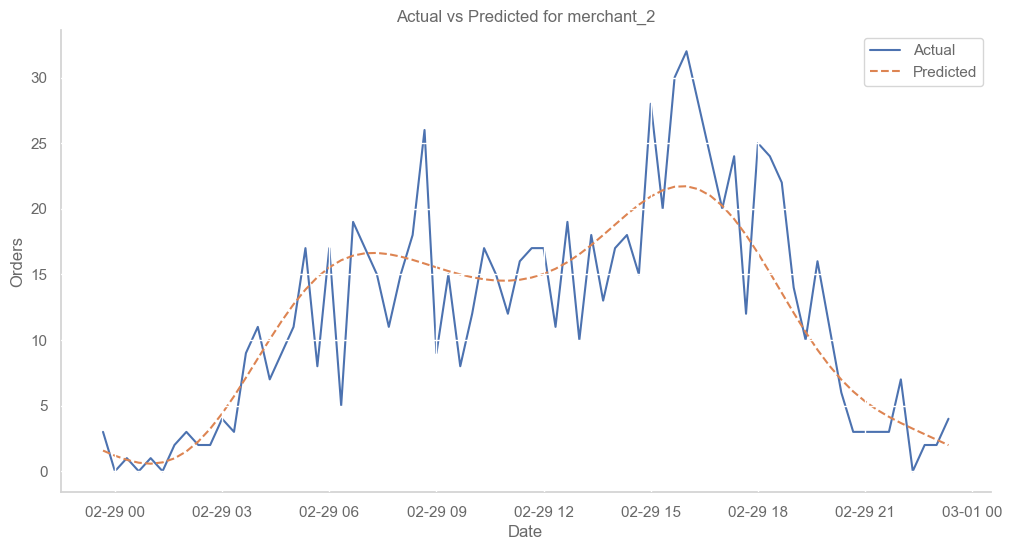

16:06:59 - cmdstanpy - INFO - Chain [1] start processing
16:07:00 - cmdstanpy - INFO - Chain [1] done processing


merchant_3 - RMSE: 2.95, MAE: 2.20


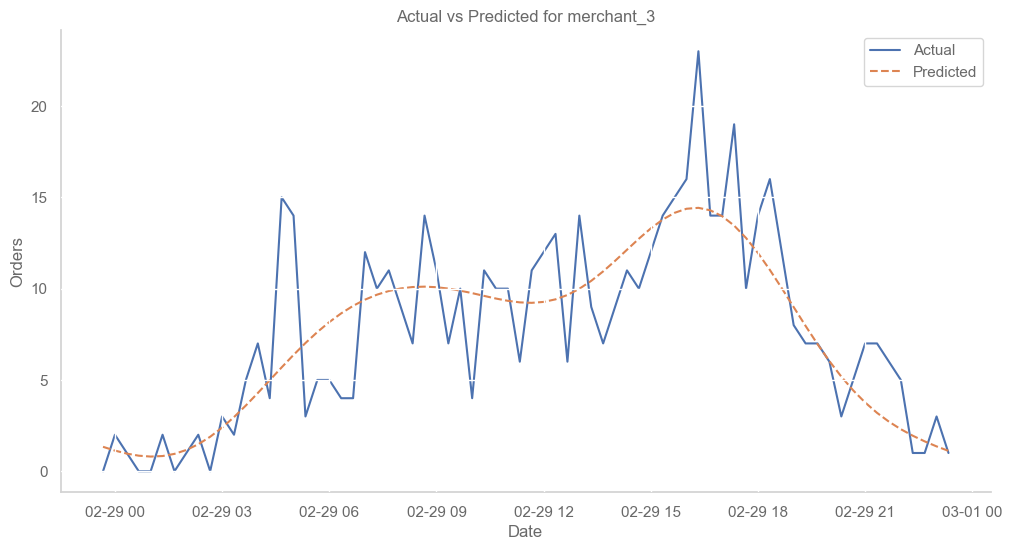

16:07:06 - cmdstanpy - INFO - Chain [1] start processing
16:07:07 - cmdstanpy - INFO - Chain [1] done processing


merchant_4 - RMSE: 4.50, MAE: 3.29


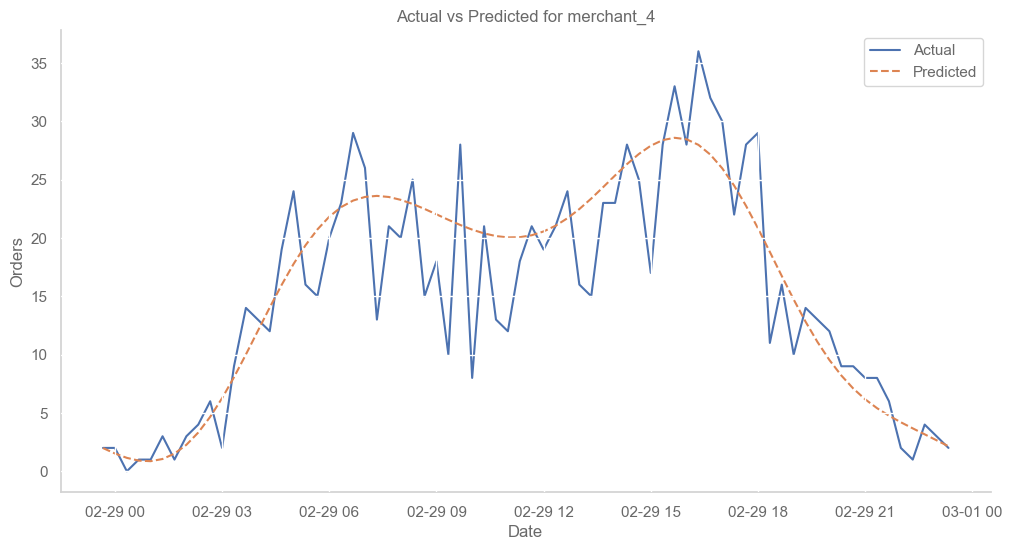

16:07:14 - cmdstanpy - INFO - Chain [1] start processing
16:07:22 - cmdstanpy - INFO - Chain [1] done processing


merchant_5 - RMSE: 4.41, MAE: 3.22


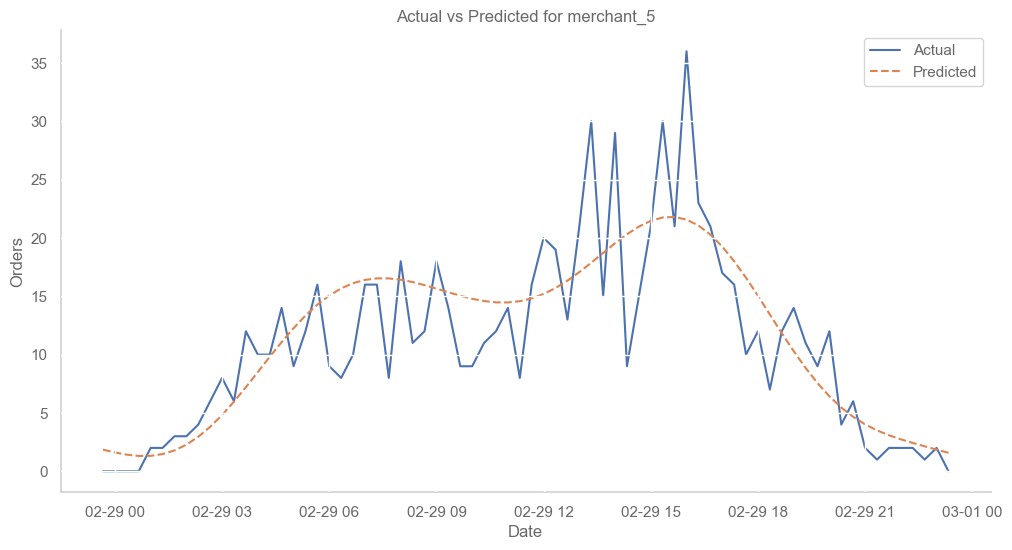

16:07:31 - cmdstanpy - INFO - Chain [1] start processing
16:07:34 - cmdstanpy - INFO - Chain [1] done processing


merchant_6 - RMSE: 2.69, MAE: 2.15


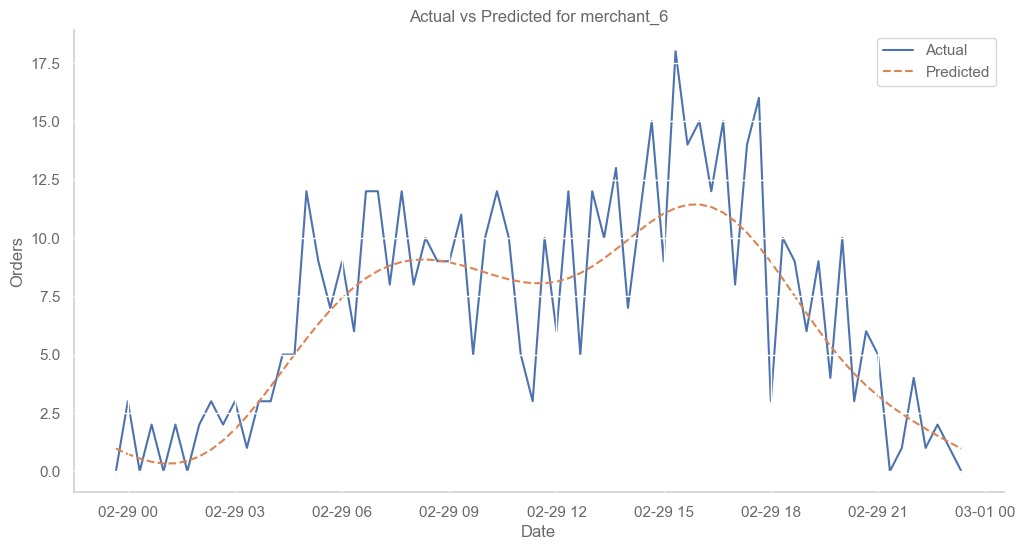

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing


merchant_7 - RMSE: 2.55, MAE: 1.94


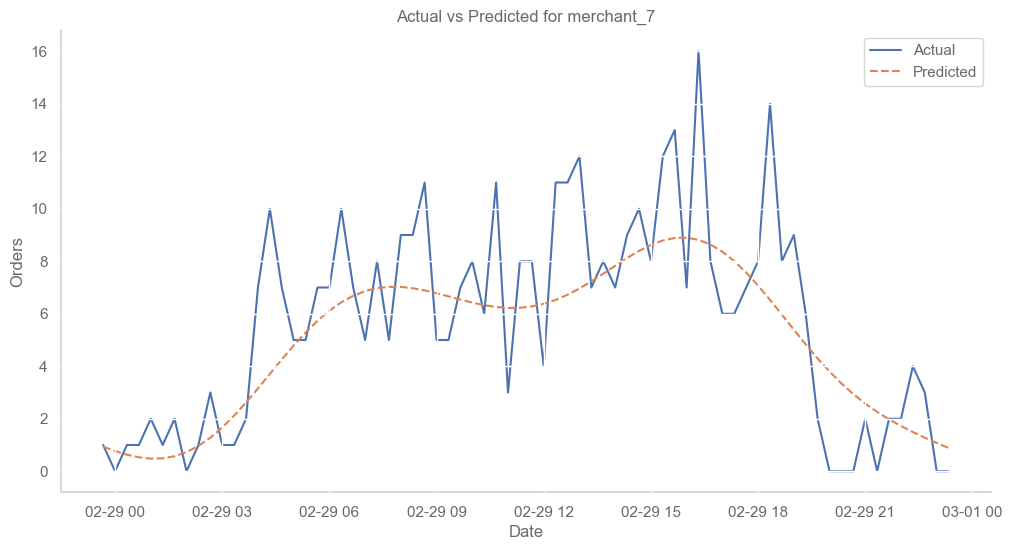

16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing


merchant_8 - RMSE: 3.25, MAE: 2.69


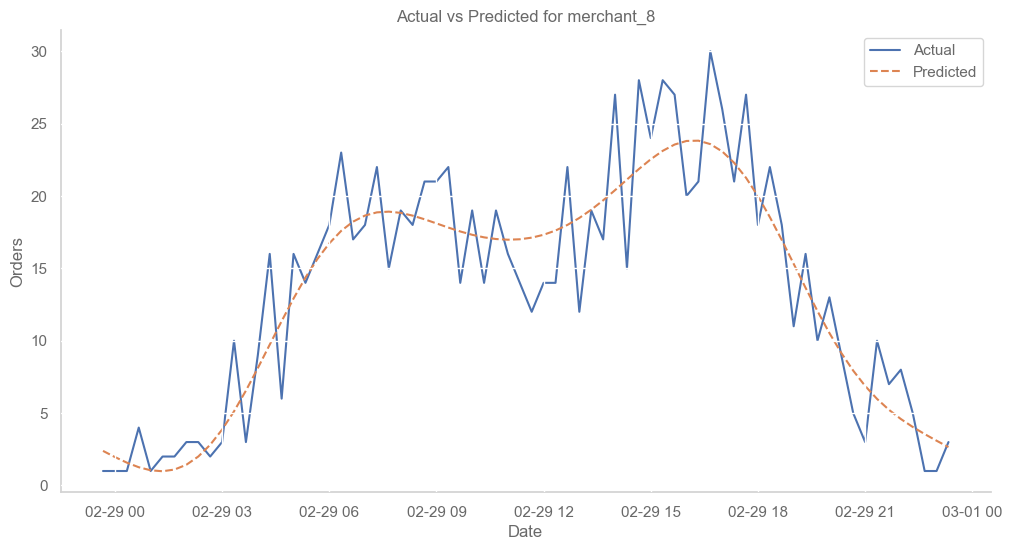

16:08:12 - cmdstanpy - INFO - Chain [1] start processing
16:08:13 - cmdstanpy - INFO - Chain [1] done processing


merchant_9 - RMSE: 3.80, MAE: 2.83


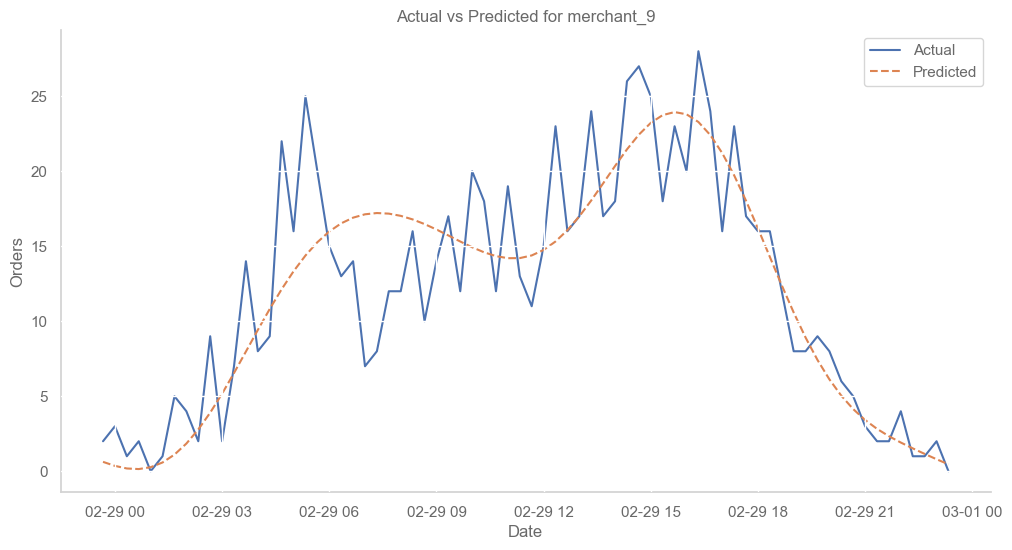

In [27]:
#PROPHET MODEL
forecasted_dfs = []

for feature in total_orders_df.columns:
    
    #formatting
    df_copy = total_orders_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
        # Model
    m = Prophet(
        changepoint_prior_scale=params_dict['changepoint_prior_scale'],
        seasonality_prior_scale=params_dict['seasonality_prior_scale'],
        holidays_prior_scale=params_dict['holidays_prior_scale'],
        seasonality_mode=params_dict['seasonality_mode'],
        changepoint_range=params_dict['changepoint_range'],
        holidays=holiday
    )
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((predicted_df['y'] - predicted_df['yhat'])**2))
    mae = np.mean(np.abs(predicted_df['y'] - predicted_df['yhat']))

    print(f"{feature} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df['ds'], predicted_df['y'], label='Actual')
    plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

### FINAL FORECASTING

In [28]:
prediction_days = 1
forecast_start_date = max(total_orders_df.index)

In [29]:
total_orders_df.columns

Index(['merchant_1', 'merchant_10', 'merchant_11', 'merchant_12', 'merchant_2',
       'merchant_3', 'merchant_4', 'merchant_5', 'merchant_6', 'merchant_7',
       'merchant_8', 'merchant_9'],
      dtype='object', name='merchant_id')

16:08:18 - cmdstanpy - INFO - Chain [1] start processing
16:08:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarn

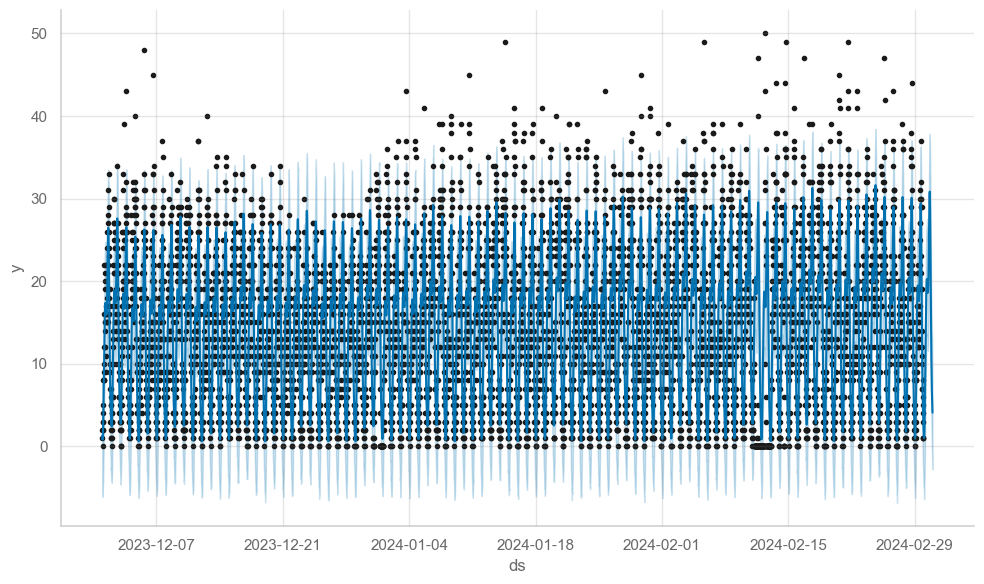

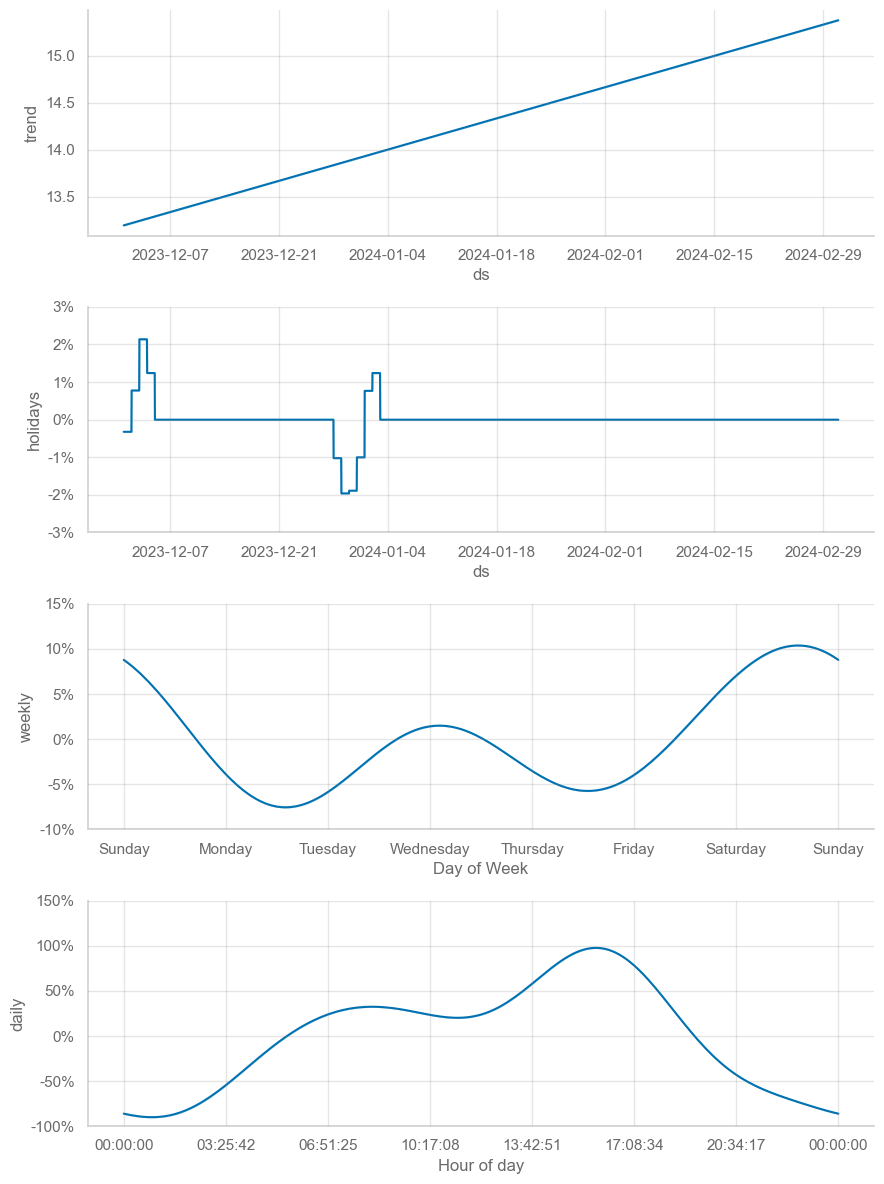

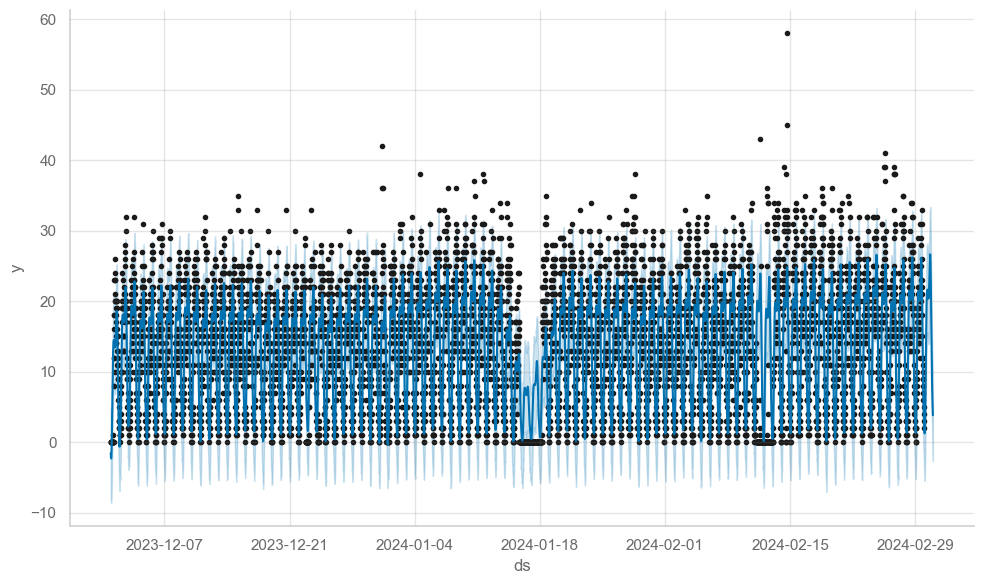

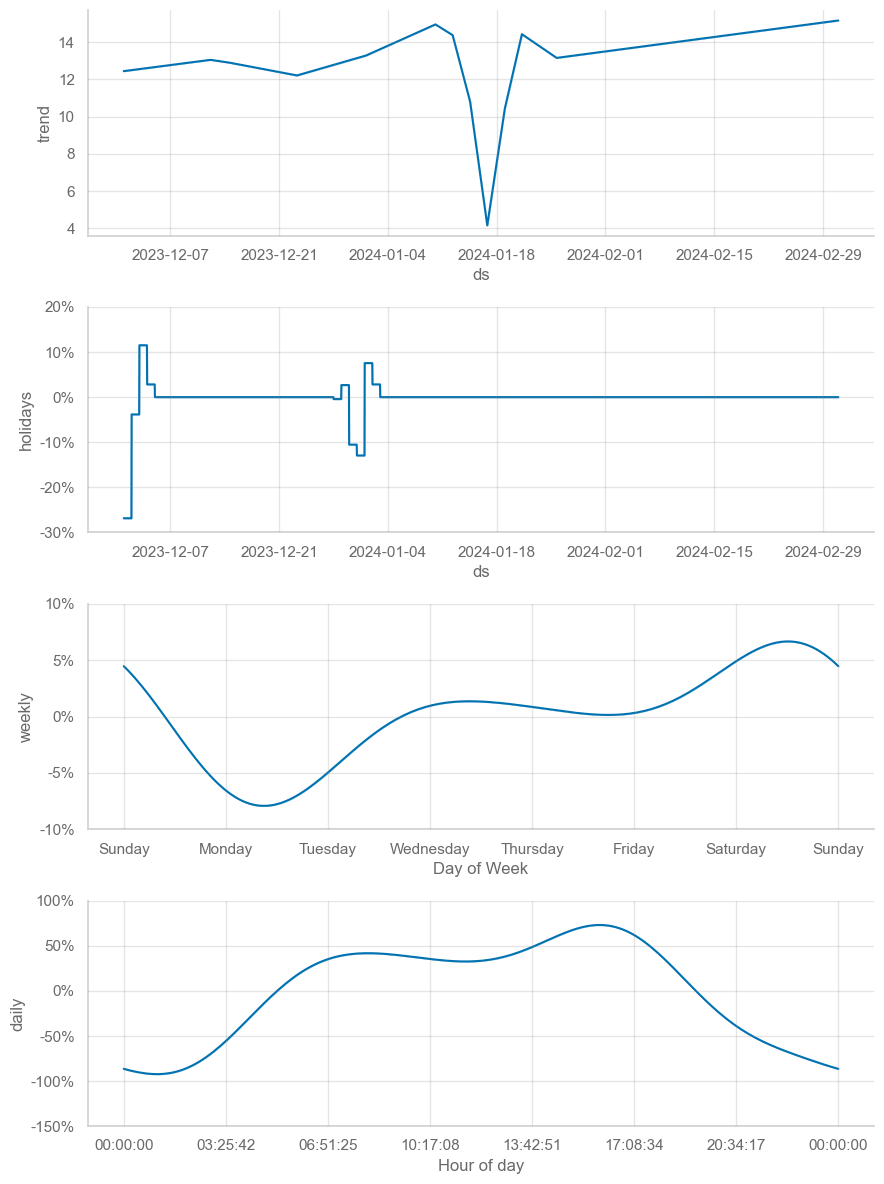

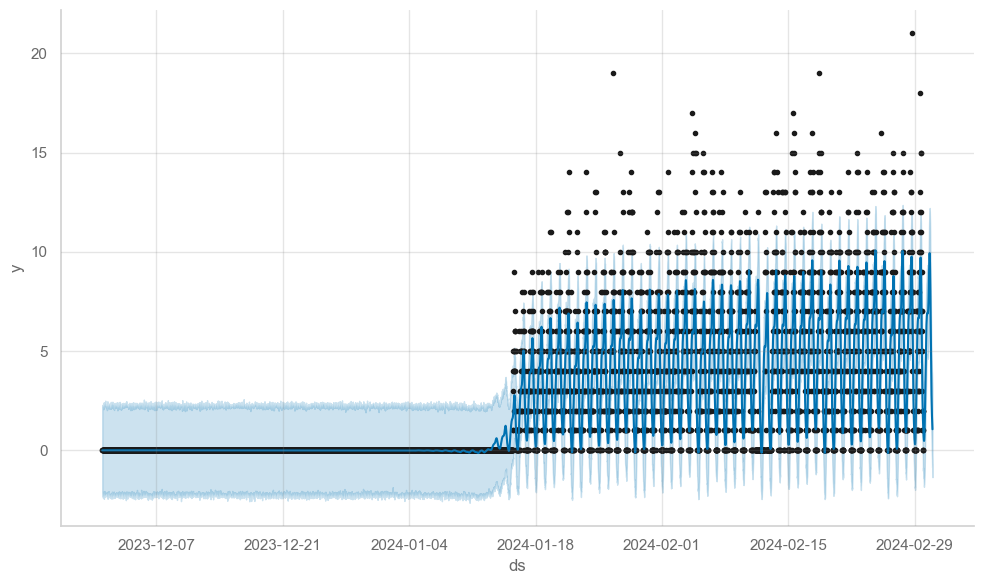

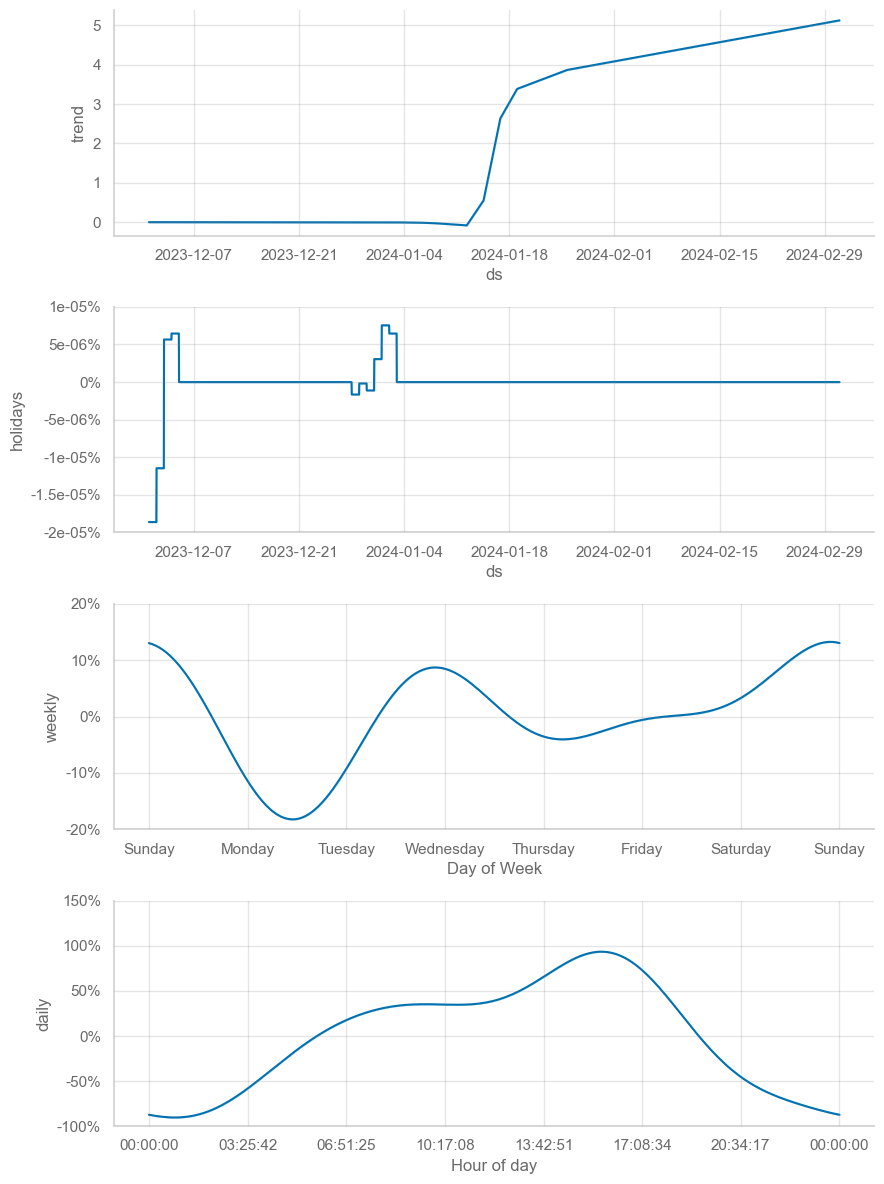

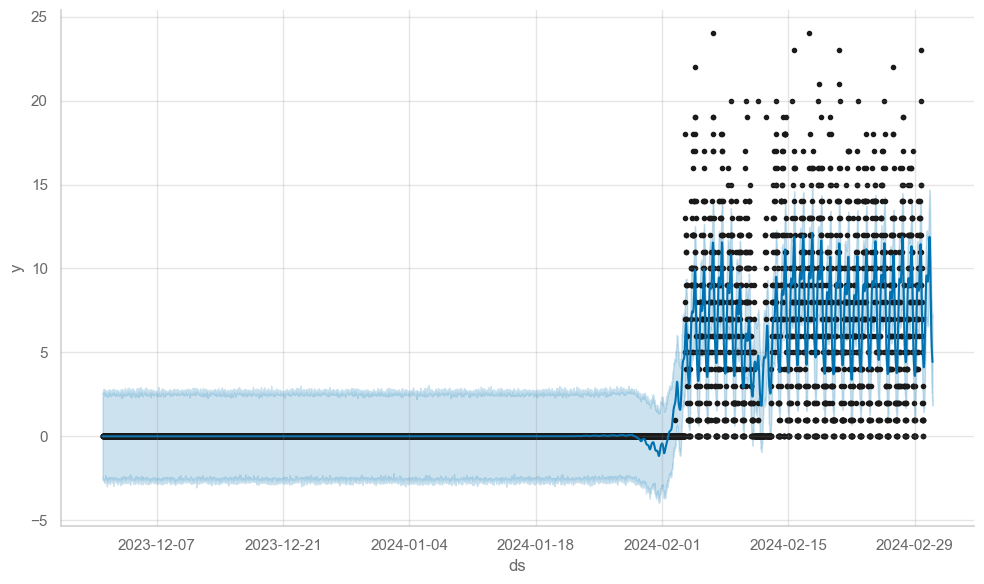

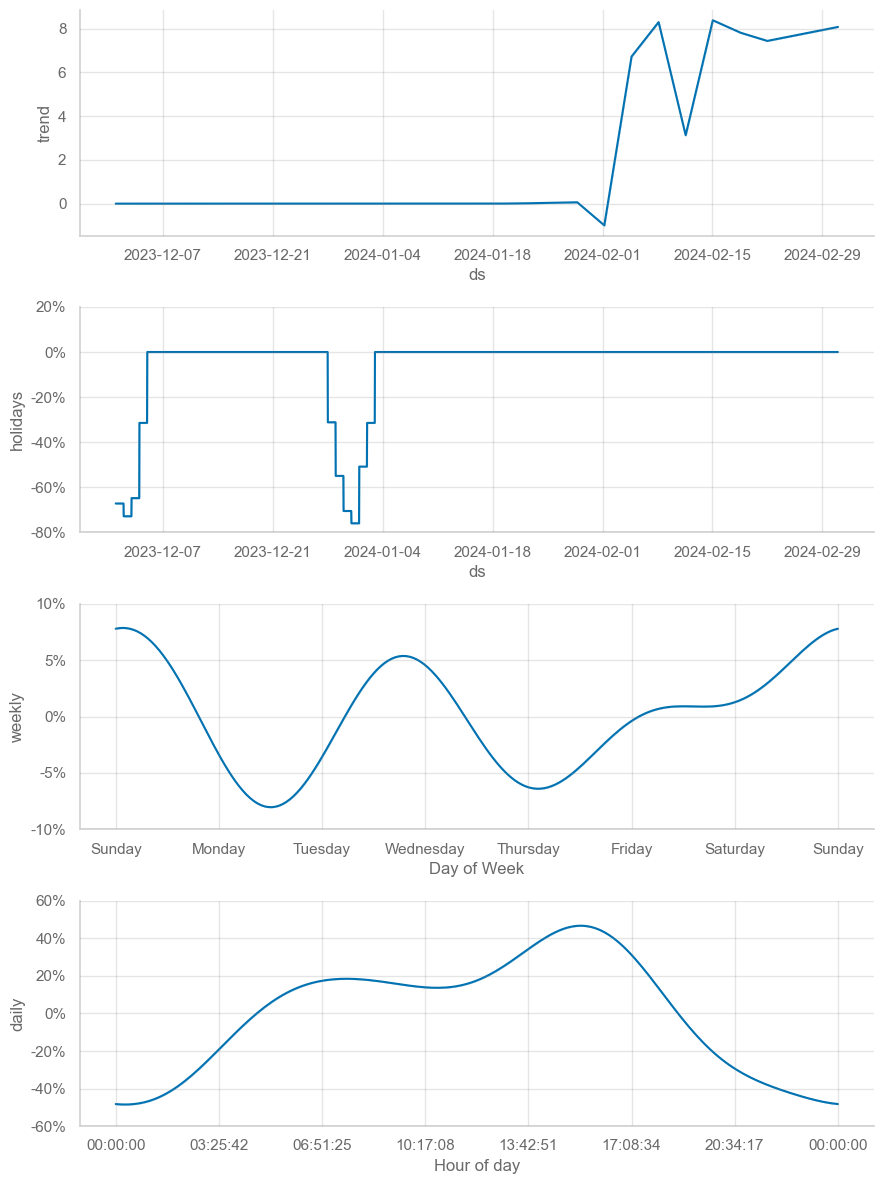

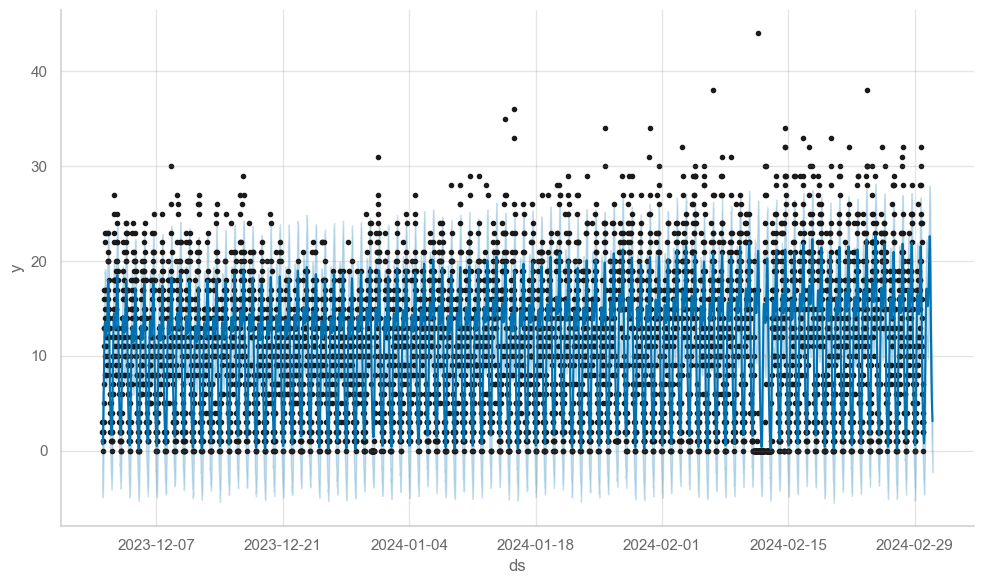

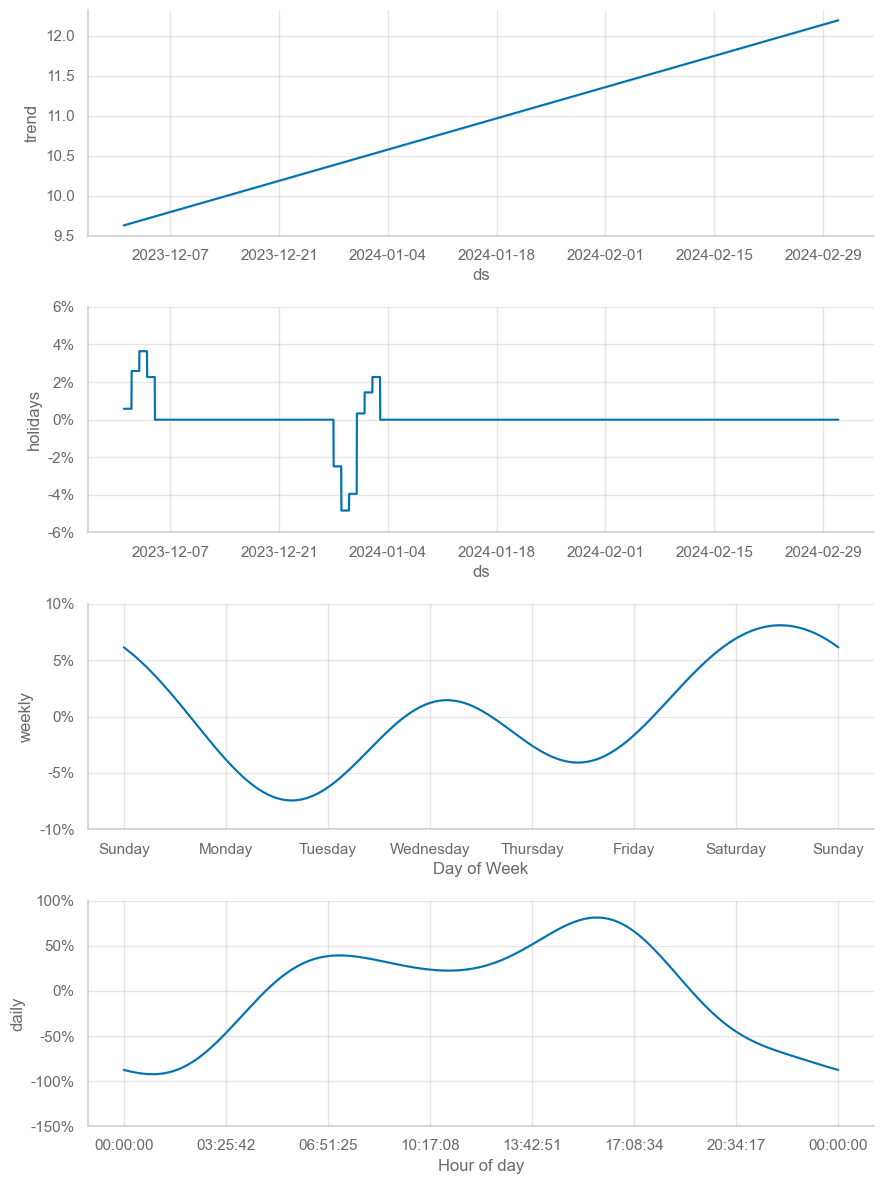

In [30]:
forecasted_dfs = []

for feature in total_orders_df.columns[:5]:
    
    # Formatting
    df_copy = total_orders_df[feature].copy().reset_index()
    df_copy.columns = ['ds', 'y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    # Finding the right params_dict for this category
    params_dict = dicts[feature]
    
    # Model
    m = Prophet(
        changepoint_prior_scale=params_dict['changepoint_prior_scale'],
        seasonality_prior_scale=params_dict['seasonality_prior_scale'],
        holidays_prior_scale=params_dict['holidays_prior_scale'],
        seasonality_mode=params_dict['seasonality_mode'],
        changepoint_range=params_dict['changepoint_range'],
        holidays=holiday
    )
    
    m.fit(df_copy_)
    
    future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)

    fig2 = m.plot_components(fcst_prophet_train)
    
    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date]
    forecasted_dfs.append(forecasted_df)


In [32]:
forecasted_df

ds  trend  yhat_lower  yhat_upper  trend_lower  \
6551 2024-02-29 23:40:00  12.16       -3.30        7.20        12.16   
6552 2024-03-01 00:00:00  12.16       -3.69        6.56        12.16   
6553 2024-03-01 00:20:00  12.16       -3.87        6.45        12.16   
6554 2024-03-01 00:40:00  12.16       -4.62        5.73        12.16   
6555 2024-03-01 01:00:00  12.16       -4.48        6.29        12.16   
6556 2024-03-01 01:20:00  12.17       -4.54        6.13        12.17   
6557 2024-03-01 01:40:00  12.17       -3.98        6.20        12.17   
6558 2024-03-01 02:00:00  12.17       -3.41        7.42        12.17   
6559 2024-03-01 02:20:00  12.17       -2.92        7.77        12.17   
6560 2024-03-01 02:40:00  12.17       -1.93        8.93        12.17   
6561 2024-03-01 03:00:00  12.17       -0.42       10.07        12.17   
6562 2024-03-01 03:20:00  12.17        0.33       11.41        12.17   
6563 2024-03-01 03:40:00  12.17        2.12       12.89        12.17   
6564 2024-03-01 04:00:00  12.17        3.58       14.31        12.17   
6565 2024-03-01 04:20:00  12.17        4.85       15.61        12.17   
6566 2024-03-01 04:40:00  12.17        6.31       17.25        12.17   
6567 2024-03-01 05:00:00  12.17        7.47       18.12        12.17   
6568 2024-03-01 05:20:00  12.17        8.80       19.42        12.17   
6569 2024-03-01 05:40:00  12.17        9.42       20.38        12.17   
6570 2024-03-01 06:00:00  12.17       10.61       20.99        12.17   
6571 2024-03-01 06:20:00  12.17       11.16       21.52        12.17   
6572 2024-03-01 06:40:00  12.17       11.99       22.15        12.17   
6573 2024-03-01 07:00:00  12.17       11.54       21.95        12.17   
6574 2024-03-01 07:20:00  12.17       12.20       22.29        12.17   
6575 2024-03-01 07:40:00  12.17       11.88       21.93        12.17   
6576 2024-03-01 08:00:00  12.17       11.67       22.16        12.17   
6577 2024-03-01 08:20:00  12.17       11.42       21.98        12.17   
6578 2024-03-01 08:40:00  12.17       11.24       21.67        12.17   
6579 2024-03-01 09:00:00  12.17       10.84       21.52        12.17   
6580 2024-03-01 09:20:00  12.17       10.74       21.17        12.17   
6581 2024-03-01 09:40:00  12.18       10.58       21.14        12.18   
6582 2024-03-01 10:00:00  12.18       10.45       20.97        12.18   
6583 2024-03-01 10:20:00  12.18       10.32       20.48        12.18   
6584 2024-03-01 10:40:00  12.18       10.32       20.30        12.18   
6585 2024-03-01 11:00:00  12.18        9.98       20.53        12.18   
6586 2024-03-01 11:20:00  12.18        9.70       20.38        12.18   
6587 2024-03-01 11:40:00  12.18       10.29       21.15        12.18   
6588 2024-03-01 12:00:00  12.18       10.42       21.14        12.18   
6589 2024-03-01 12:20:00  12.18       10.86       21.28        12.18   
6590 2024-03-01 12:40:00  12.18       11.61       21.72        12.18   
6591 2024-03-01 13:00:00  12.18       11.57       21.99        12.18   
6592 2024-03-01 13:20:00  12.18       12.80       23.20        12.18   
6593 2024-03-01 13:40:00  12.18       12.80       24.09        12.18   
6594 2024-03-01 14:00:00  12.18       14.24       24.61        12.18   
6595 2024-03-01 14:20:00  12.18       15.11       25.73        12.18   
6596 2024-03-01 14:40:00  12.18       15.79       26.71        12.18   
6597 2024-03-01 15:00:00  12.18       16.90       26.81        12.18   
6598 2024-03-01 15:20:00  12.18       17.22       27.46        12.18   
6599 2024-03-01 15:40:00  12.18       17.19       27.84        12.18   
6600 2024-03-01 16:00:00  12.18       17.43       27.97        12.18   
6601 2024-03-01 16:20:00  12.18       17.42       27.65        12.18   
6602 2024-03-01 16:40:00  12.18       16.70       27.20        12.18   
6603 2024-03-01 17:00:00  12.18       15.88       26.42        12.18   
6604 2024-03-01 17:20:00  12.18       15.05       25.67        12.18   
6605 2024-03-01 17:40:00  12.18       13.48       23.99       